In [1]:
import pickle
import pandas as pd
import numpy as np
from data_cleaning import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from util import *
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("precision", 3)
sns.set_context("talk") # talk context is good for RISE presentations

### **1. Read the data**

In [3]:
fn = ("../data/vehicle_value_data.pickle")
with open(fn,'rb') as read_file:
    df = pickle.load(read_file)

### **2. Data cleaning**
    Now, the data is clean without Nan values.

In [4]:
# The data is clean 
df2 = data_cleaning(df)
df2.head(10)


,make,year,mileage,fuel_type,drive_type,transmission,engine_size,engine_type,cty_mpg,hwy_mpg,price
0,INFINITI,2017,46423,gas,awd,automatic,3.50,regular,19,26,27690
1,Chevrolet,2017,40653,gas,awd,automatic,3.60,regular,17,24,28589
2,Jeep,2020,11994,gas,awd,automatic,2.40,regular,22,30,24900
5,Mercedes-Benz,2013,76867,gas,awd,automatic,3.50,regular,20,28,14995
6,Nissan,2019,29537,gas,fwd,automatic,2.50,regular,27,37,17995
7,Ford,2014,98388,gas,awd,automatic,1.60,turbo,22,30,11995
8,Ford,2015,69024,gas,awd,automatic,3.50,regular,17,23,19995
9,Subaru,2012,98464,gas,awd,automatic,2.00,regular,27,36,8995
10,Toyota,2015,109274,gas,fwd,automatic,1.80,regular,29,38,10995
13,Mercedes-Benz,2014,101449,gas,awd,automatic,3.50,regular,21,29,17995


### **3. Visualization and data inspection**

For all the scraped data, the first thing to look at is the top 10 most popular makes. Toyota ranks the first and is followed by Honda and Ford. Others in top 10 makes are Chevy, Jeep, Nissan, BMW, Audi, Mazda, and  Subaru. This figure leaves customers with an idea of what makes should be focused on so that they can narrow down the searching range. 

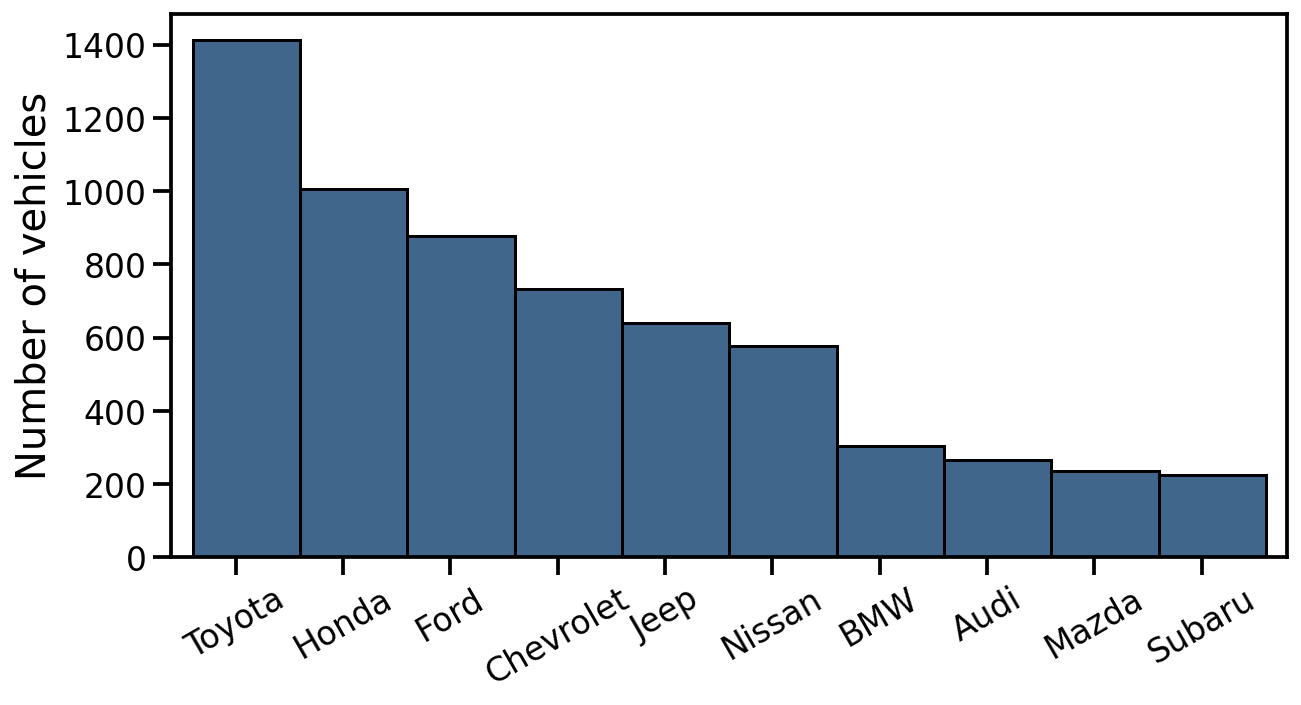

In [5]:
plt.subplots(figsize=(10,5))
make_counts = df["make"].value_counts()
make_counts = make_counts[:10]
ax= sns.barplot(make_counts.index,
                make_counts.values,
                color=(0.2, 0.4, 0.6),
                edgecolor=(0,0,0),
                linewidth=1.5
               )
ax.set_ylabel("Number of vehicles", fontsize=20);
ax.set_xticklabels(make_counts.index,
                   rotation=30,                  
                  );
[t_ax.set_width(1) for t_ax in ax.patches];
ax.set_xlim([-0.6,9.8]);
plt.savefig("../figures/top10_makes.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

Most of used vehicles are priced within the range of \\$12k to \\$30k. But there are some luxary vehicles 

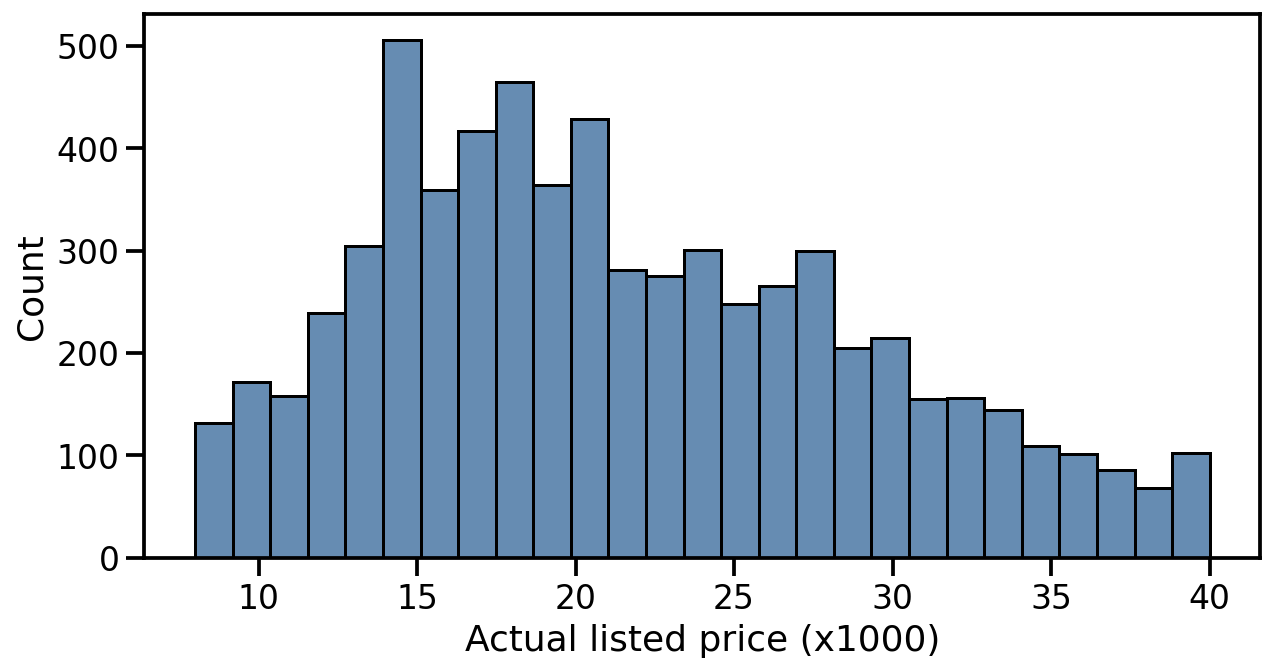

In [6]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(df2["price"]/1000,  color=(0.2, 0.4, 0.6));
ax.grid(False)
ax.set_xlabel("Actual listed price (x1000)");
plt.savefig("../figures/hist_listed_price.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

#### **Pairplot and heatmap**
The figure demonstrates that vehicle price is positively correlated with year, negatively correlated with mileage and city (or highway) MPG as expected. It suggests that a more recent and more efficient vehicle is worth more value. City (or highway) MPG is somehow negatively correlated with engine size, suggesting that larger engine (more powerful) leads to lower MPG. In addition, a larger engine size would increase the value of a vehicle.

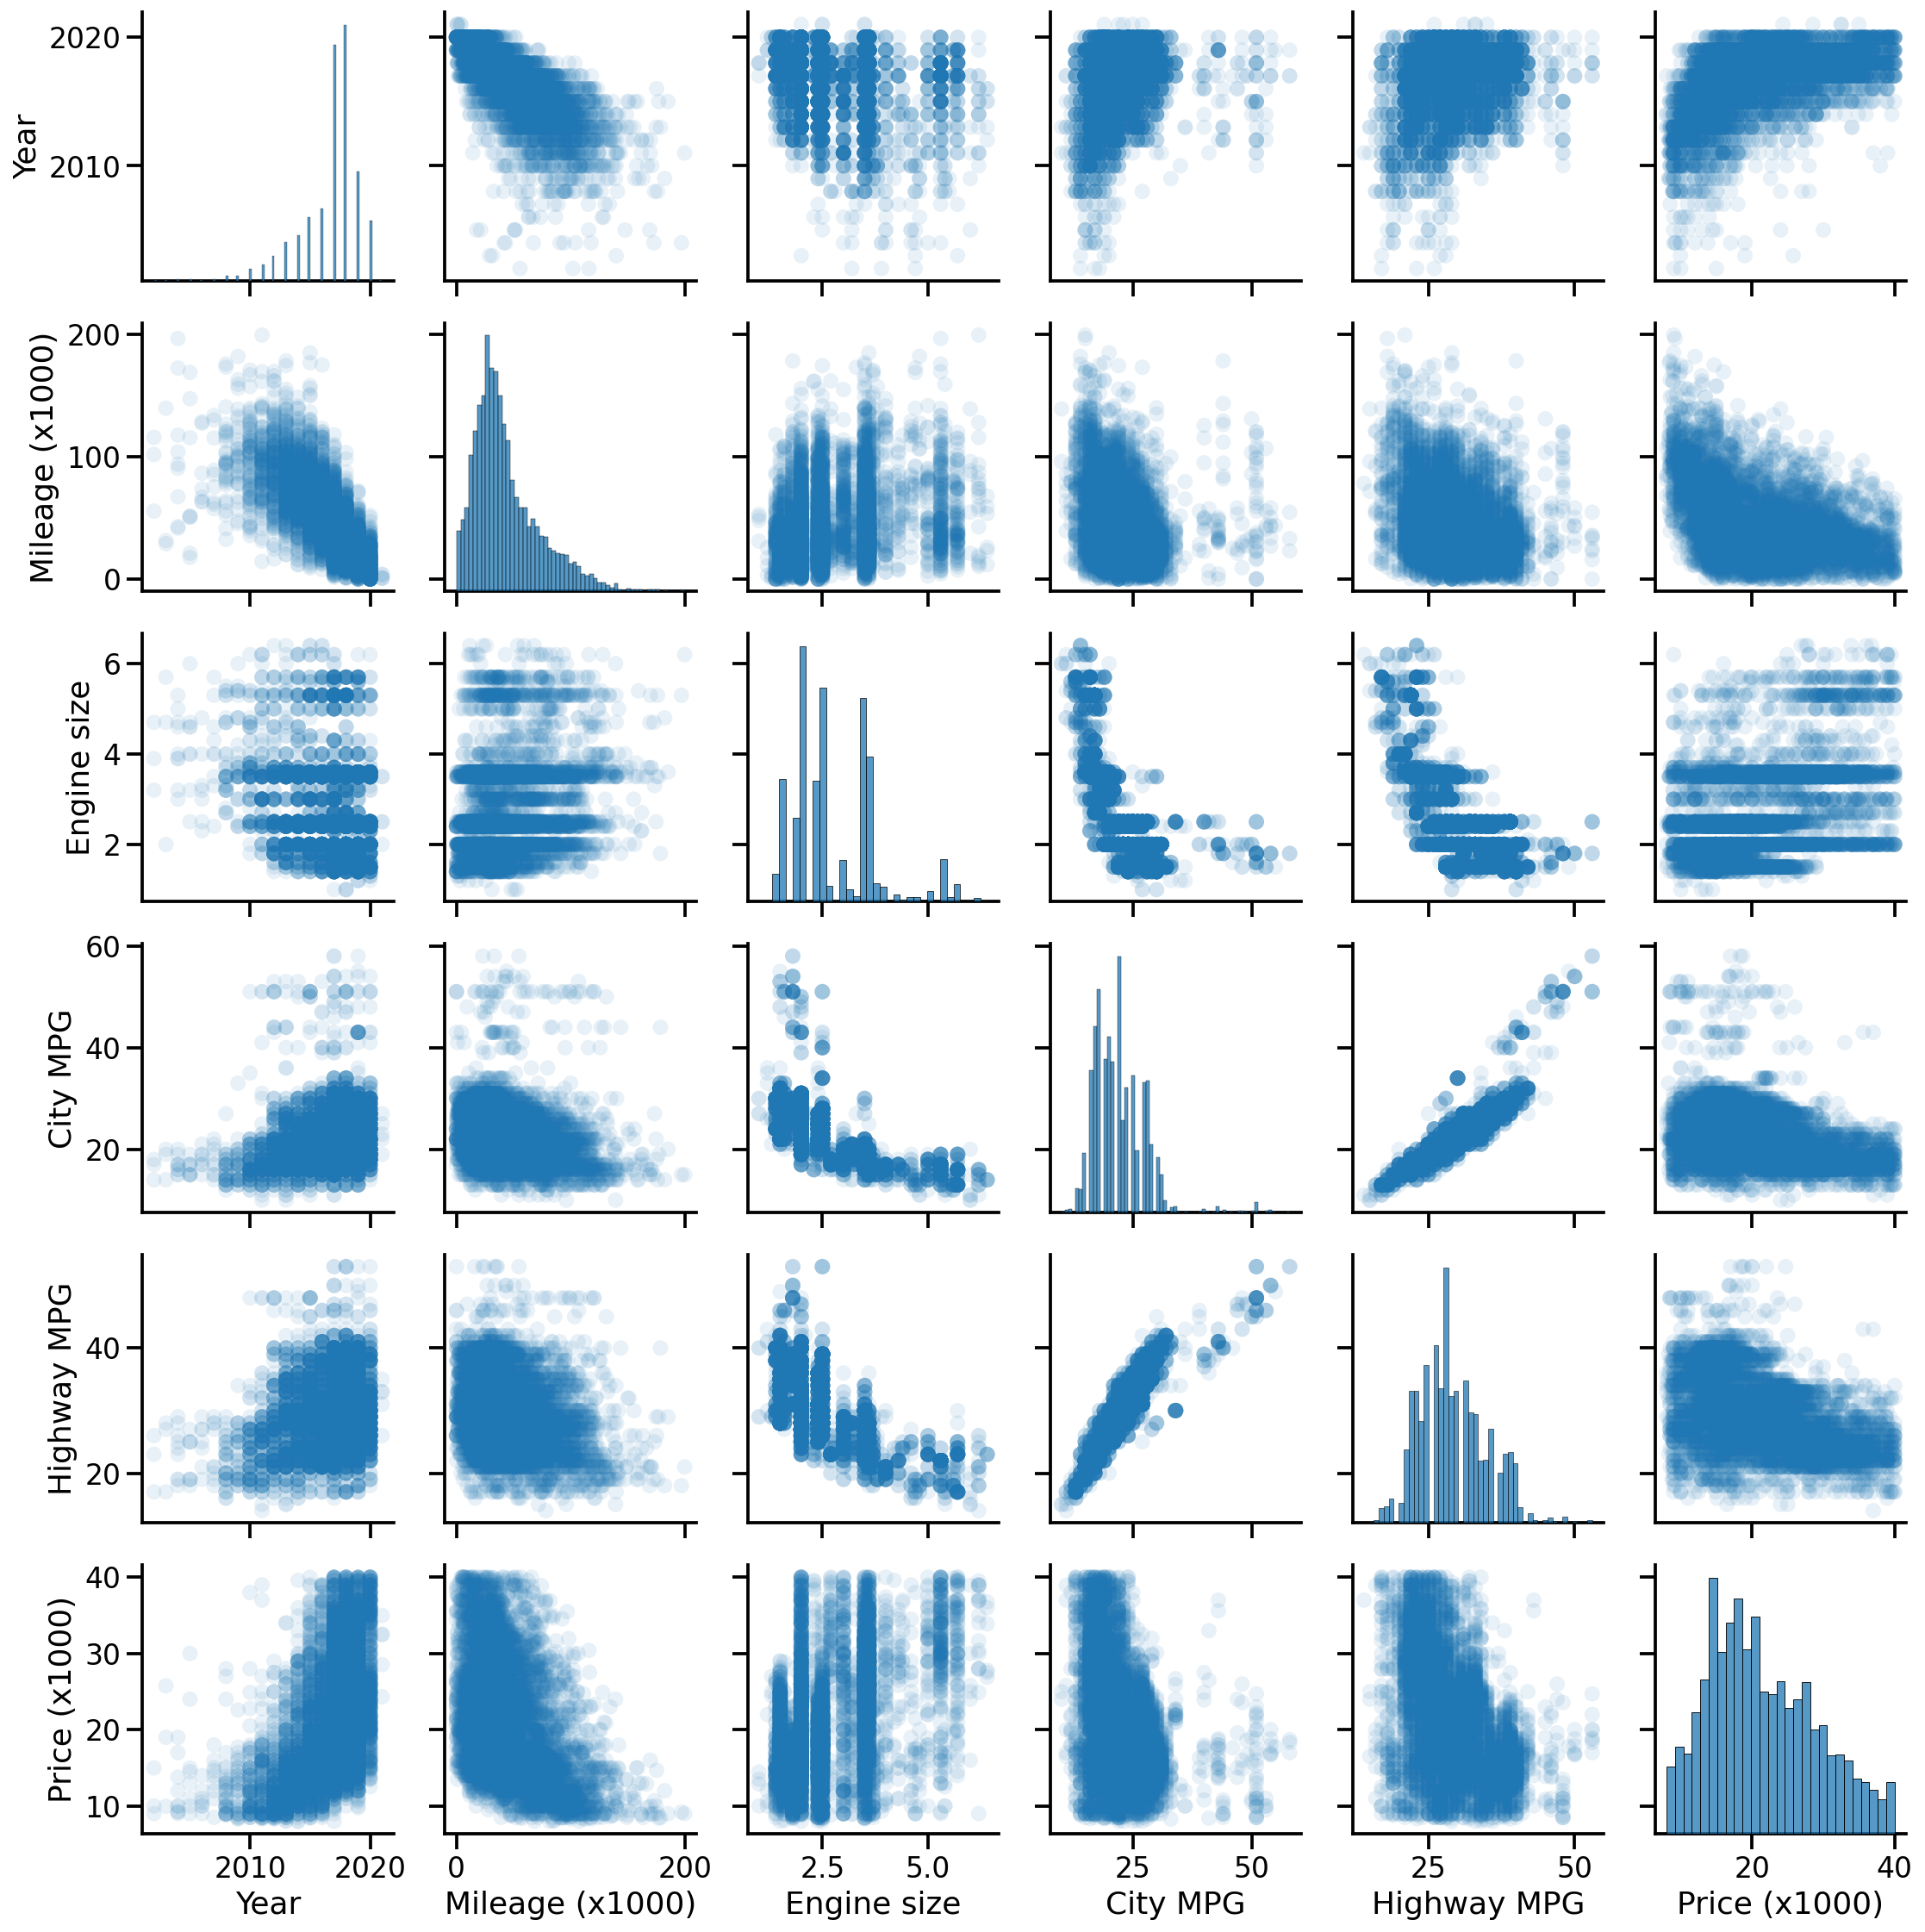

In [7]:
labels=["Year", "Mileage (x1000)", "Engine size", "City MPG", "Highway MPG", "Price (x1000)"]
# bette to scale mileage and price (only) for visualization
data_to_plot = df2.copy()
data_to_plot["mileage"] = data_to_plot["mileage"]/1000
data_to_plot["price"] = data_to_plot["price"]/1000
ax = sns.pairplot(data_to_plot, plot_kws=dict(alpha=.1, edgecolor='none'));
ax.fig.set_size_inches(16,16)
for i, e in enumerate(labels):
    ax.axes[i][0].set_ylabel(e)
    ax.axes[5][i].set_xlabel(e)
    
plt.savefig("../figures/pairplot.png",
            dpi=300, bbox_inches='tight', facecolor="white") 

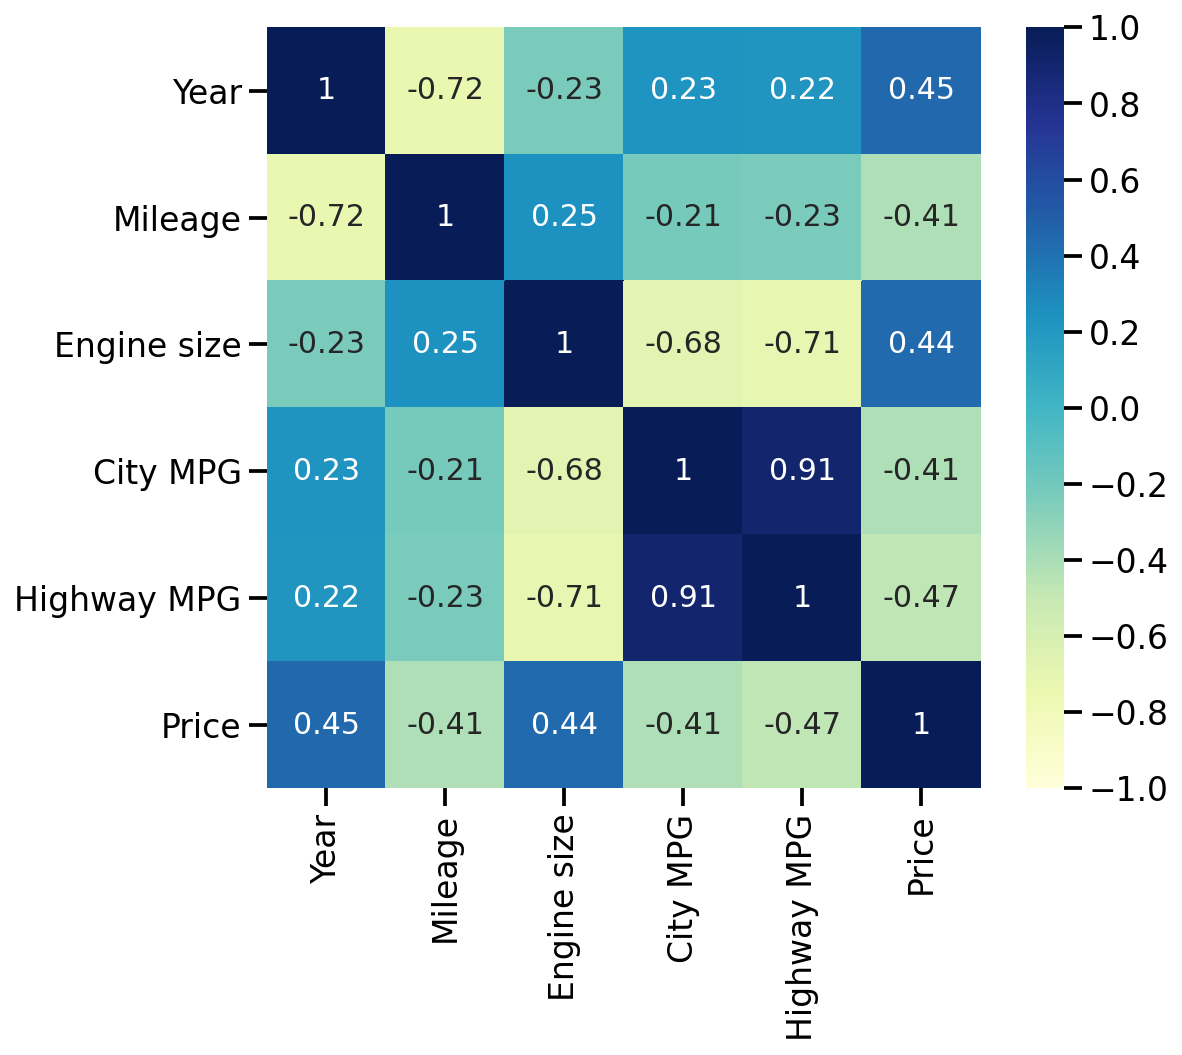

In [8]:
labels=["Year", "Mileage", "Engine size", "City MPG", "Highway MPG", "Price"]
plt.subplots(figsize=(8,7))
ax = sns.heatmap(df2.corr(),
                 cmap= "YlGnBu",
                 annot=True,
                 annot_kws={"fontsize":15},
                 xticklabels=labels, 
                 yticklabels=labels,
                 vmin=-1, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-1, 1, 11))
ax.set_xticklabels(labels, rotation=90,horizontalalignment="center")
plt.savefig("../figures/corrcoef.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

### **4. Regression analysis**
#### Workflow
- Split the entire dataset into training and testing data.
- Data pre-processing:
    - Data standardization
    - Necessary feature engineering - add interaction features 
     * Interaction between city MPG and drive type. Rear-wheel drive typically has more powerful acceleration because this layout generates more force on rear tires using the same amount of gas as front-wheel drive does.
     * Interaction between transmission type and city MPG. Typically, a vehicle with manual transmission and high MPG comes with a low price
     * Interaction between fuel type and city MPG. A hybrid engine with a high city MPG typically induces high price.
    - Split the training dataset into k (k = 5) folds of training and validation datasets
    - Transform categorical values to numerical values and standardize numerical variables for each pair of training and validation datasets    
    - Perform linear regression with a ridge regularization for each pair of training and validation datasets
    - Fit a regression model with a ridge regularization using the entire training dataset
    - Examine the model performance using the independent testing dataset

#### **4.1 Split the training data into training and testing datasets (80% vs 20%)**

In [9]:
X, y = df2.drop('price',axis=1), df2['price']
testing_portion = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_portion, random_state=15)

#### **4.2 Select features to include and set up variables**
Highway MPG is discarded as it is highly correlated with city MPG (_r_ of 0.91)

In [10]:
feats_cont = ["year", "mileage", "engine_size", "cty_mpg"];
feats_cat = ["fuel_type", "drive_type", "engine_type", "transmission"]

X_train_cont = X_train[feats_cont]
X_train_cat = X_train[feats_cat]

X_test_cont = X_test[feats_cont]
X_test_cat = X_test[feats_cat]

#### **4.3 Split the training dataset into 5 folds of training and validation datasets**

In [11]:
num_of_fold = 5
dict_kf = k_fold_split(num_of_fold, X_train_cont, X_train_cat, y_train)






#### **4.4 Convert categorical values into numerical values and standardize continuous variables**

In [12]:
X_train_vf, y_train_vf, X_val_vf, y_val_vf = feature_tform_kf(dict_kf, num_of_fold)
X_train_vf[0].head(3)

,year,mileage,engine_size,cty_mpg,Xfuel_type_gas,Xfuel_type_hybrid,Xdrive_type_fwd,Xdrive_type_rwd,Xengine_type_turbo,Xtransmission_manual
0,-0.27,2.43,-0.26,3.26,0.00,1.00,1.00,0.00,0.00,0.00
1,-1.08,2.16,0.75,-0.75,1.00,0.00,0.00,0.00,0.00,0.00
2,-1.08,2.89,-0.36,0.16,1.00,0.00,0.00,0.00,0.00,0.00


#### **4.5 Feature engineering - add interaction features**

In [13]:
feat_interact = [
                 ["Xdrive_type_fwd", "cty_mpg"],
                 ["Xdrive_type_rwd", "cty_mpg"],
                 ["Xtransmission_manual", "cty_mpg"],
                 ["cty_mpg", "Xfuel_type_hybrid"]
                ]

X_train_modified_vf, X_val_modified_vf = [], []
for i in range(0,num_of_fold):
    for fa, fb in feat_interact:        
        t_x_train, t_x_val = add_interaction_features(fa, fb,
                                                      X_train_vf[i],
                                                      X_val_vf[i],
                                                     )
    X_train_modified_vf.append(t_x_train)
    X_val_modified_vf.append(t_x_val)

#### **4.6 Perform 5-fold cross validation**
Select the best alpha value for Ridge regression based on mean square error

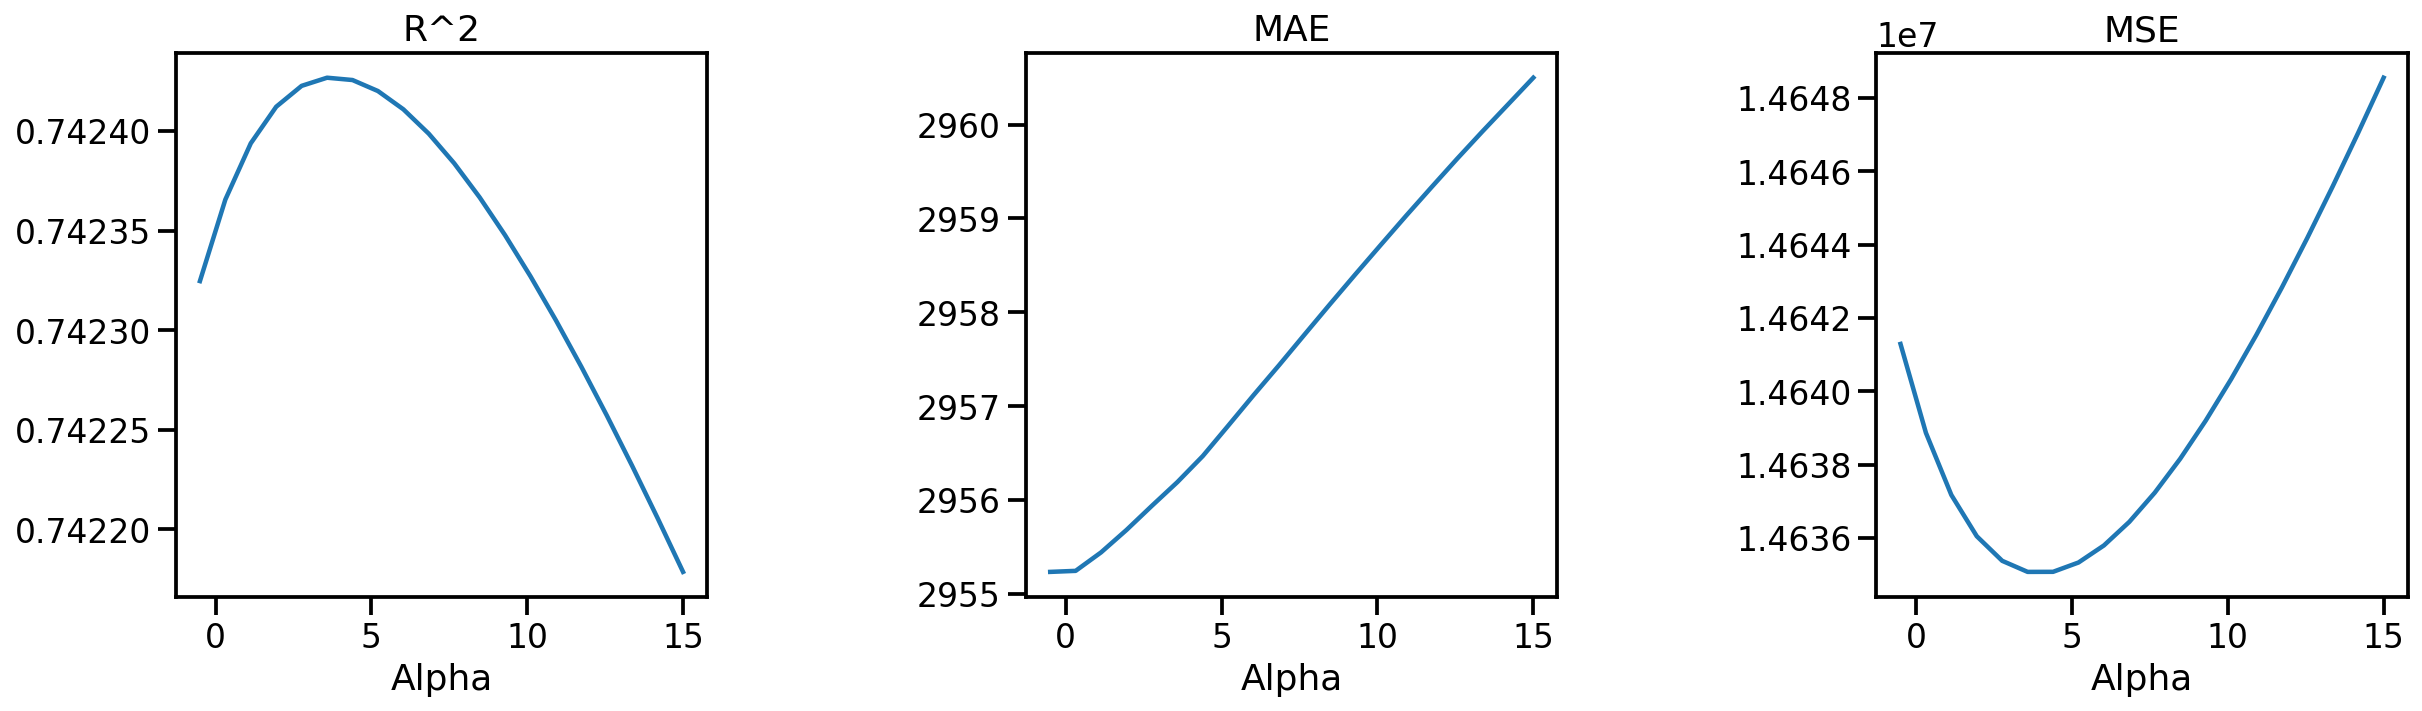

In [14]:
alpha_list = np.linspace(-0.5, 15, 20) # with an increment of 1
cv_rsq, cv_mae, cv_mse = lin_regres(X_train_modified_vf,
                                    y_train_vf,
                                    X_val_modified_vf,
                                    y_val_vf,
                                    alpha_list,
                                    method="ridge"
                                   )

plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace = 0.6)
ax1 = plt.subplot(1, 3, 1)
plt.plot(alpha_list, cv_rsq)
ax1.set_xlabel("Alpha");
ax1.set_title("R^2");
ax2 = plt.subplot(1, 3, 2)
plt.plot(alpha_list, cv_mae)
ax2.set_title("MAE");
ax2.set_xlabel("Alpha");
ax3 = plt.subplot(1, 3, 3)
plt.plot(alpha_list, cv_mse)
ax3.set_title("MSE");
ax3.set_xlabel("Alpha");
plt.savefig("../figures/errors.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

In [15]:
i_min = np.argmin(cv_mse)
ord_r2 = cv_rsq[i_min]
sample_size, n_of_feat = X_train_modified_vf[0].shape
adj_r2 = adjusted_r2(ord_r2, sample_size, n_of_feat)

print("Training R^2={:.2f}".format(adj_r2))
print("Training MAE={:.2f}".format(cv_mae[i_min]))
print("Training MSE={:.2f}".format(cv_mse[i_min]))
print("--------------------------")

Training R^2=0.74
Training MAE=2956.19
Training MSE=14635071.51
--------------------------


#### **4.7 Perform section 4.5 and 4.6 for the entire training dataset**

#### **4.7.1 Transform features (same as section 4.4)**

In [16]:
dict_all = {"X_train_cont": X_train_cont,
             "X_train_cat": X_train_cat,
             "y_train": y_train, 
             "X_test_cont": X_test_cont,
             "X_test_cat": X_test_cat,
             "y_test": y_test
             }

X_train_all, y_train_all, X_test_all, y_test_all = feature_tform(dict_all)

#### **4.7.2 Add interaction features the entire training dataset (same sa section 4.6)**

In [17]:
X_train_modified_all, X_test_modified_all = [], []

for fa, fb in feat_interact:        
    X_train_modified_all, X_test_modified_all = add_interaction_features(fa, fb,
                                                  X_train_all,
                                                  X_test_all,
                                                 )

#### **4.7.3 Perform Ridge linear regression using the entire training dataset**

In [18]:
lm, y_pred_all, r2_all, mae_all, mse_all =  lin_regres([X_train_modified_all], [y_train_all],
                                                       [X_test_modified_all], [y_test_all],
                                                       [cv_rsq[i_min]])
print("Testing R^2={:.2f}".format(r2_all[0]))
print("Testing MAE={:.2f}".format(mae_all[0]))
print("Testing MSE={:.2f}".format(mse_all[0]))
print("--------------------------")

Testing R^2=0.72
Testing MAE=3008.07
Testing MSE=15502073.77
--------------------------


#### **4.8 Inspect results** 
- The p-value from F test suggests the multivariate linear regression is significant.
- The comparison between predicted and actual vehicle prices demonstrates that for the model appears to perform better when predicting the actual price within the range of \\$12k to \\$30k than when predicting the actual price >\\$30k and <\\$12k. This is expected because there are not sufficient data points in this range (Fig. 2; histogram). Therefore, the regression model does not capture sufficient characteristics for these data.
- The residuals have no specific pattern/trend relative to predicted price (both linear regression coef and R^2 are 0).
- The normal Q-Q plot suggests that residuals are normally distributed, but with negative skewness. This suggests that the model is likely to underestimate the actual vehicle price. 


In [19]:
dfn = X_train_modified_all.shape[1]
dfd = X_train_modified_all.shape[0] - X_train_modified_all.shape[1] - 1
p_val_f_test, F = calculate_f_stats(r2_all[0], dfn, dfd)
print("p-val from F test = {:.2f}".format(p_val_f_test))
print("F value from F test = {:.2f}".format(F))

p-val from F test = 0.00
F value from F test = 979.84


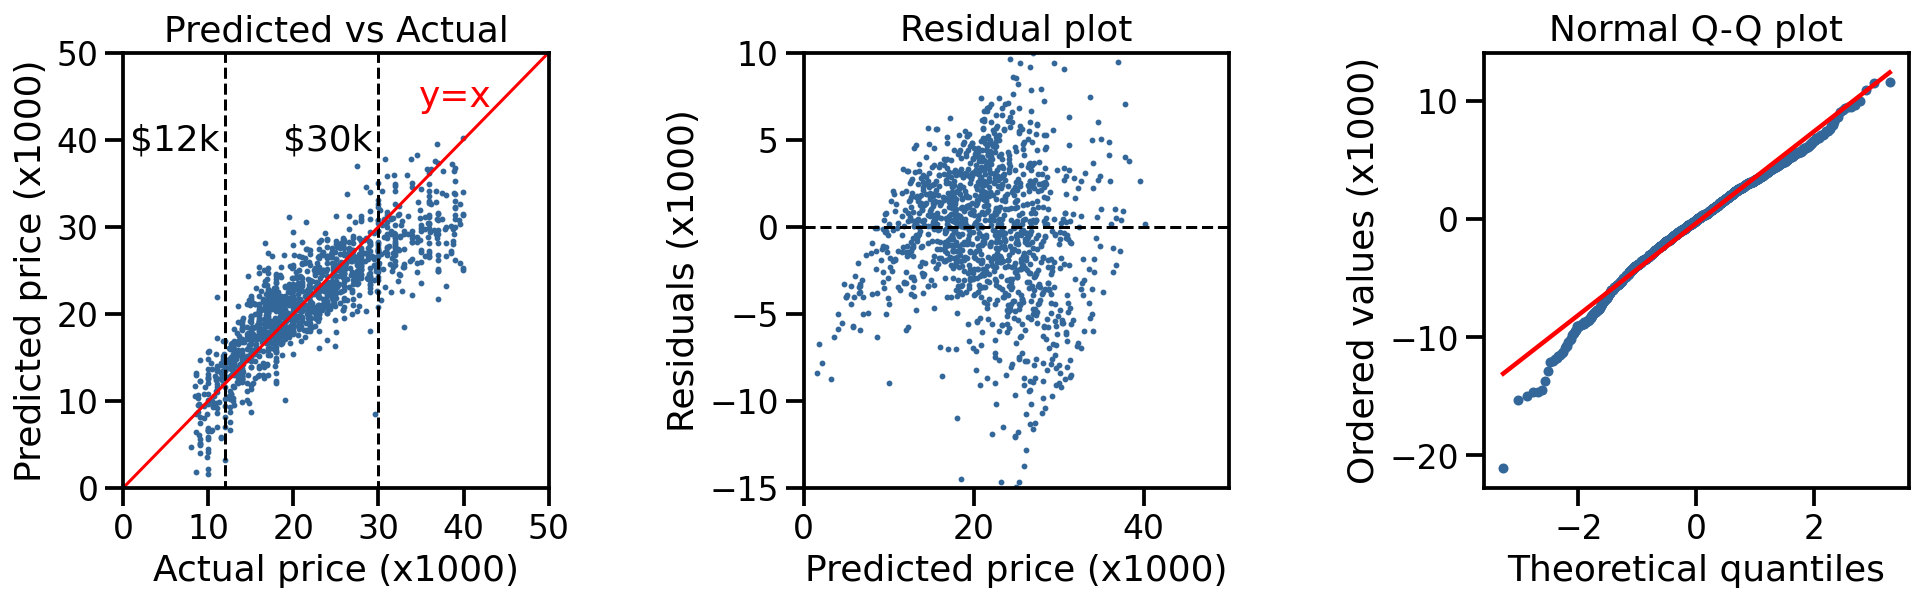

In [20]:
y_pred_all = y_pred_all.reshape(y_test.shape)
residuals = y_pred_all - y_test
diagnose_plot(y_pred_all, y_test)
plt.savefig("../figures/results_inspection.svg",
            dpi=300, bbox_inches='tight', facecolor="white")

#### **4.8.2 Additional regression analysis for residuals w.r.t predicted price**
No pattern and trend between residuals and predicted price are opbserved (lin. reg. coef of 0 and R^2 of 0 ). 

In [21]:
mdl = LinearRegression()
mdl.fit(y_pred_all.reshape(len(y_pred_all), 1)/1000, residuals.to_numpy().reshape(len(y_pred_all), 1)/1000)
res_r2 = mdl.score(y_pred_all.reshape(len(y_pred_all), 1)/1000, residuals.to_numpy().reshape(len(y_pred_all), 1)/1000)
res_coef = mdl.coef_[0][0]
print("R^2 between residuals and predicted price = {:,.2f}".format(res_r2))
print("Lin. reg. coef. = {:,.2f}".format(res_coef))

R^2 between residuals and predicted price = 0.00
Lin. reg. coef. = -0.01


#### **4.9 Summary of the influence of vehicle features on price**
The summary is based on the bar graph of linear regression coefficients below.

- Top 5 potential features that would increase the price of a used vehicle:
    * Equipped with a turbo-charged engine
    * Rear-wheel drive layout
    * Large-sized engine
    * A more recent car
    * Equipped with a hybrid engine
    
    
    

- Top 5 potential features that would lower the price of a used vehicle:
    * Front-wheel drive layout
    * High mileage
    * High city MPG
    * Using gas
    * Manual Transmission with high city MPG
    



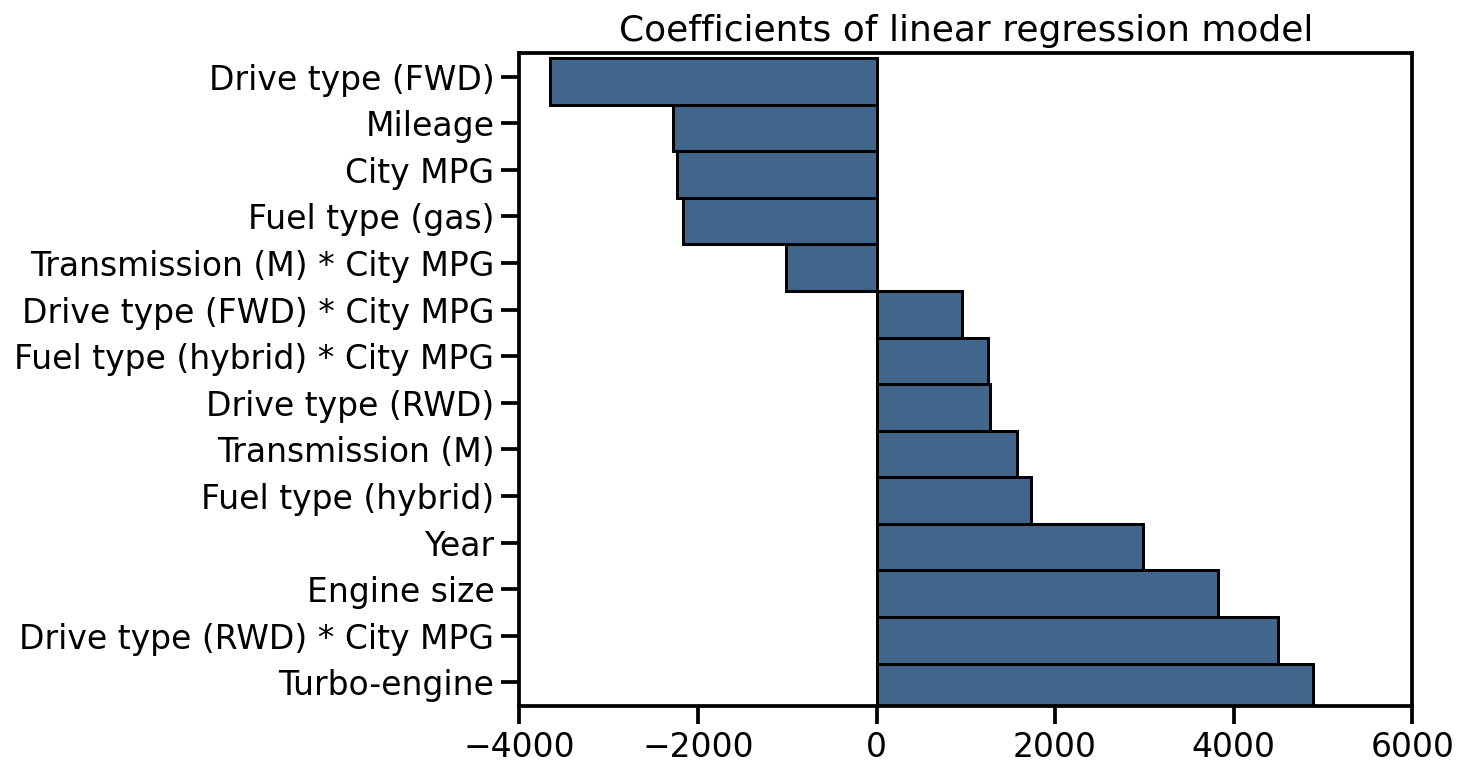

In [22]:
idx = np.argsort(lm.coef_[0])
y_data = np.array(X_train_modified_all.columns)
x_data = lm.coef_[0]
plt.subplots(figsize=(8, 6))
ax = sns.barplot(x_data[idx], y_data[idx],
            color=(0.2, 0.4, 0.6),
            edgecolor=(0,0,0),
            linewidth=1.5)
[t_ax.set_height(1) for t_ax in ax.patches];
y_ticklabels = ["Drive type (FWD)", "Mileage", "City MPG", "Fuel type (gas)",
                "Transmission (M) * City MPG", "Drive type (FWD) * City MPG",
                "Fuel type (hybrid) * City MPG", "Drive type (RWD)",
                "Transmission (M)", "Fuel type (hybrid)", "Year", "Engine size",
                "Drive type (RWD) * City MPG", "Turbo-engine"]
                
ax.set_yticklabels(y_ticklabels);
ax.set_xlim([-4000, 6000]);
ax.set_title("Coefficients of linear regression model")
plt.savefig("../figures/lm_coef.svg",
            dpi=300, bbox_inches='tight', facecolor="white")